# Get feature importance / SHAP values

In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as pl
import ml_help
from time import time
import seaborn as sns
sns.set_theme()

In [2]:
flow_df = pd.read_csv("./data/gardiner_flow.csv.zip")
weather_df = pd.read_csv("./data/weather_data.csv.zip")
flow_df["collectedAt"] = pd.to_datetime(flow_df["collectedAt"],utc=True)
weather_df["collectedAt"] = pd.to_datetime(weather_df["collectedAt"],utc=True)
flow_df.drop(['month', 'day', 'day_of_week', 'hour', 'minute'],inplace=True,axis=1)
weather_df.drop(['windDegree', 'month', 'day', 'day_of_week', 'day_of_week_name', 'hour', 'minute'],inplace=True,axis=1)

df = flow_df.merge(weather_df,on="collectedAt",how="inner")
df["month"] = df.collectedAt.dt.month
df["day_of_week"] = df.collectedAt.dt.weekday
df["day"] = df.collectedAt.dt.day
df["hour"] = df.collectedAt.dt.hour
df["minute"] = df.collectedAt.dt.minute
df.drop("collectedAt",inplace=True,axis=1)
df

,currentSpeed,visibility,temperature,FeelsLike,humidity,windSpeed,cloudsAll,rain1h,snow1h,cloudy,clear,atmosphere,snowy,rainy,month,day_of_week,day,hour,minute
0,94,10.0,18.69,18.68,79,2.57,0,0.0,0.0,0,1,0,0,0,7,3,14,12,45
1,94,10.0,19.16,19.17,78,2.57,0,0.0,0.0,0,1,0,0,0,7,3,14,12,51
2,75,10.0,19.16,19.17,78,2.57,0,0.0,0.0,0,1,0,0,0,7,3,14,12,55
3,72,10.0,19.38,19.36,76,2.57,0,0.0,0.0,0,1,0,0,0,7,3,14,13,0
4,94,10.0,19.42,19.40,76,2.57,0,0.0,0.0,0,1,0,0,0,7,3,14,13,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73530,92,10.0,9.77,6.07,41,9.26,0,0.0,0.0,0,1,0,0,0,3,6,26,21,35
73531,92,10.0,9.77,6.07,41,9.26,0,0.0,0.0,0,1,0,0,0,3,6,26,21,40
73532,79,10.0,9.64,5.90,40,9.26,0,0.0,0.0,0,1,0,0,0,3,6,26,21,45
73533,92,10.0,9.61,5.86,40,9.26,0,0.0,0.0,0,1,0,0,0,3,6,26,21,50


In [3]:
categorical_feats = ["month","day_of_week"]

transformed_df = pd.get_dummies(df, columns=categorical_feats)
transformed_df = transformed_df.astype("float32")
transformed_df

,currentSpeed,visibility,temperature,FeelsLike,humidity,windSpeed,cloudsAll,rain1h,snow1h,cloudy,...,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,94.0,10.0,18.690001,18.680000,79.0,2.57,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,94.0,10.0,19.160000,19.170000,78.0,2.57,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,75.0,10.0,19.160000,19.170000,78.0,2.57,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,72.0,10.0,19.379999,19.360001,76.0,2.57,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,94.0,10.0,19.420000,19.400000,76.0,2.57,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73530,92.0,10.0,9.770000,6.070000,41.0,9.26,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
73531,92.0,10.0,9.770000,6.070000,41.0,9.26,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
73532,79.0,10.0,9.640000,5.900000,40.0,9.26,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
73533,92.0,10.0,9.610000,5.860000,40.0,9.26,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
X = transformed_df.drop("currentSpeed",axis=1)
y = transformed_df["currentSpeed"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.80 = 0.20

# XGBoost

Fitting...
Fitting... OK! Took 11.476498365402222 seconds
Explaining...
Explaining... OK! Took 13.603274583816528 seconds
Calculating shap values...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Calculating shap values... OK! Took 4.593798637390137 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


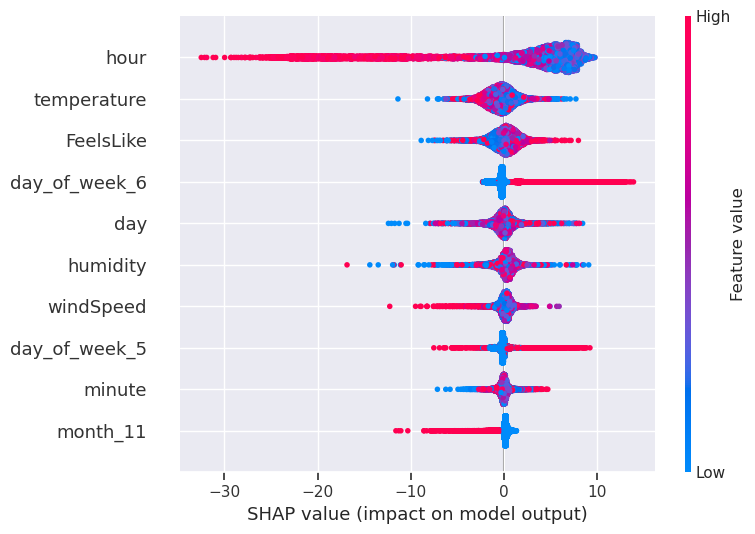

In [5]:
import xgboost as xgb

params = ml_help.params_to_dict("043_xgboost")
model = xgb.XGBRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.TreeExplainer(model)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
xgboost_fig = pl.gcf()
pl.savefig("./plots/046_xgboost.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/046_xgboost.png", bbox_inches="tight")

# Random Forest

Fitting...
Fitting... OK! Took 10.454959630966187 seconds
Explaining...
Explaining... OK! Took 0.010756492614746094 seconds
Calculating shap values...
Calculating shap values... OK! Took 27.033345937728882 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


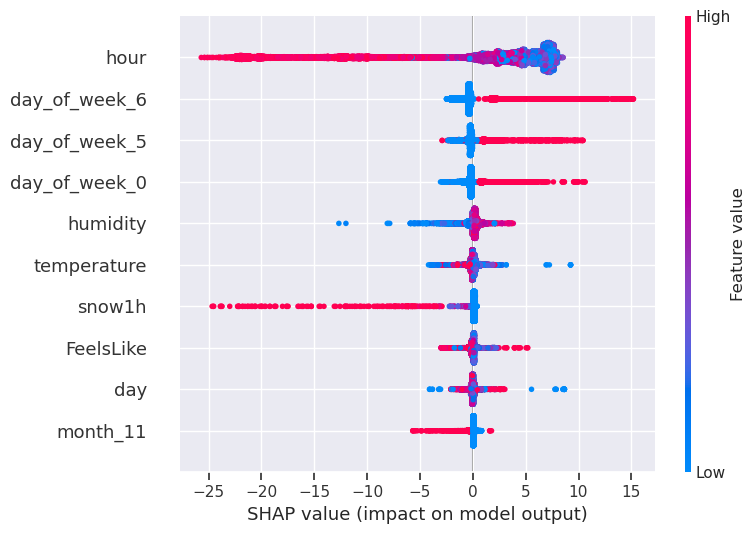

In [6]:
from sklearn.ensemble import RandomForestRegressor

params = ml_help.params_to_dict("043_random_forest")
model = RandomForestRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.TreeExplainer(model)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
pl.savefig("./plots/046_random_forest.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/046_random_forest.png", bbox_inches="tight")

# Decision Tree

Fitting...
Fitting... OK! Took 0.14255380630493164 seconds
Explaining...
Explaining... OK! Took 0.0005393028259277344 seconds
Calculating shap values...
Calculating shap values... OK! Took 0.2471022605895996 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


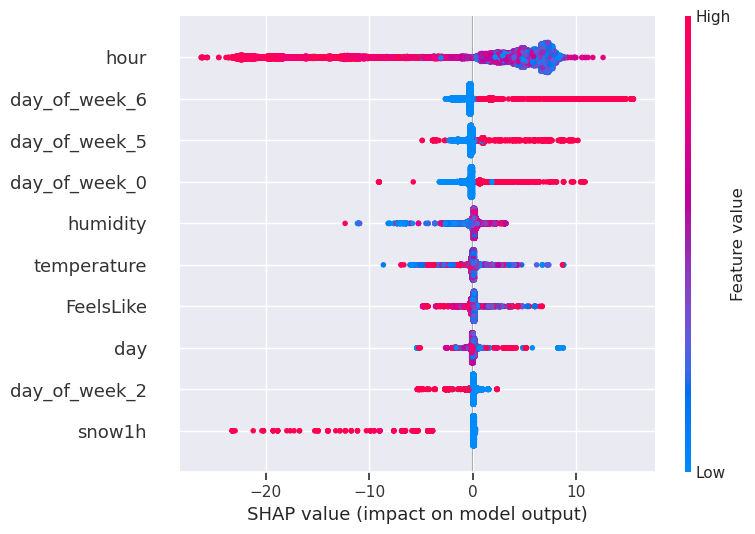

In [7]:
from sklearn.tree import DecisionTreeRegressor

params = ml_help.params_to_dict("043_decision_tree")
model = DecisionTreeRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.TreeExplainer(model)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
pl.savefig("./plots/046_decision_tree.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/046_decision_tree.png", bbox_inches="tight")

# MLP

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Fitting...
Fitting... OK! Took 268.33719420433044 seconds
Explaining...
Explaining... OK! Took 0.0008337497711181641 seconds
Calculating shap values...


X does not have valid feature names, but MLPRegressor was fitted with feature names


  0%|          | 0/14707 [00:00<?, ?it/s]

Calculating shap values... OK! Took 2658.096792936325 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


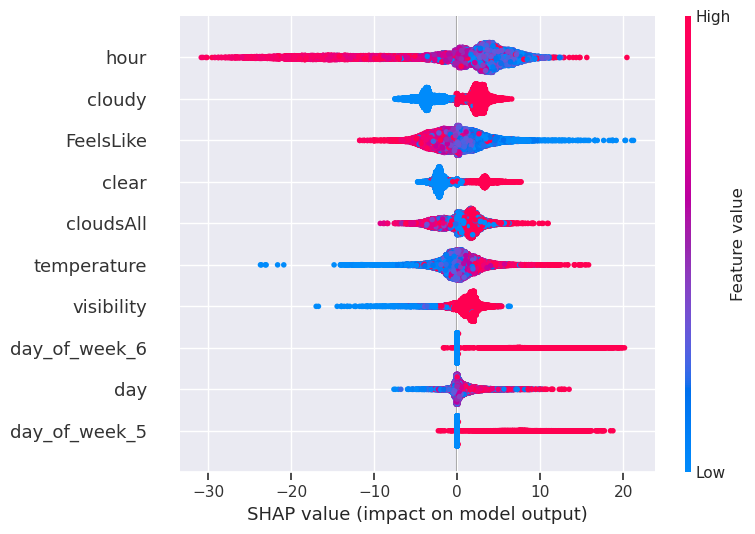

In [8]:
from sklearn.neural_network import MLPRegressor
import warnings

X_train_summary = shap.kmeans(X_train, 10)

params = ml_help.params_to_dict("043_mlpr")
model = MLPRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.KernelExplainer(model.predict, X_train_summary)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
pl.savefig("./plots/046_mlp.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/046_mlp.png", bbox_inches="tight")